# Experiment 1: Direct Imputation Comparison

This experiment compares the direct imputation performance of four methods:
1. Ordinary Linear Regression
2. Hierarchical Linear Regression
3. Ordinary Gaussian Process
4. Hierarchical Gaussian Process

We artificially mask values in one column and evaluate imputation accuracy using MSE.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from models.linear_regression import LinearRegression
from models.gaussian_process import GaussianProcessRegression
from imputation.chained_imputer import ChainedImputer

# Set random seed for reproducibility
np.random.seed(42)
sns.set_style('whitegrid')

## 1. Generate or Load Test Dataset

In [2]:
# Generate synthetic dataset with hierarchical structure
n_samples = 200
n_groups = 4

# Create group labels
groups = np.random.choice(['A', 'B', 'C', 'D'], size=n_samples)

# Group-specific offsets (random effects)
group_effects = {'A': 2.0, 'B': -1.5, 'C': 1.0, 'D': -0.5}

# Generate features
X1 = np.random.randn(n_samples)
X2 = np.random.randn(n_samples)
X3 = np.random.randn(n_samples)  # This will be masked

# Generate target with hierarchical structure
y = 3.0 * X1 + 2.0 * X2 + 1.5 * X3
for i, group in enumerate(groups):
    y[i] += group_effects[group]
y += np.random.randn(n_samples) * 0.5  # Add noise

# Create DataFrame
data = pd.DataFrame({
    'group': groups,
    'x1': X1,
    'x2': X2,
    'x3': X3,
    'y': y
})

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

Dataset shape: (200, 5)

First few rows:
  group        x1        x2        x3         y
0     C  0.087047  0.199060  0.576557  1.968808
1     D -0.299007 -0.600217  0.311250 -1.254445
2     A  0.091761  0.069802  3.078881  7.501047
3     C -1.987569 -0.385314  1.119575 -3.418194
4     C -0.219672  0.113517 -0.127918  0.736979


## 2. Artificially Mask Data

In [3]:
# Mask 30% of x3 values
mask_ratio = 0.3
n_mask = int(n_samples * mask_ratio)
mask_indices = np.random.choice(n_samples, size=n_mask, replace=False)

# Store true values for evaluation
true_values = data.loc[mask_indices, 'x3'].copy()

# Create masked dataset
data_masked = data.copy()
data_masked.loc[mask_indices, 'x3'] = np.nan

print(f"Masked {n_mask} values ({mask_ratio*100:.0f}%) in column 'x3'")
print(f"Missing values: {data_masked.isnull().sum()['x3']}")

Masked 60 values (30%) in column 'x3'
Missing values: 60


## 3. Perform Imputation with Four Methods

In [4]:
# Method 1: Ordinary Linear Regression
print("Method 1: Ordinary Linear Regression")
imputer_lr = ChainedImputer(
    base_model=LinearRegression(),
    random_effects=None,
    n_imputations=5,
    random_state=42
)
imputed_lr = imputer_lr.fit_transform(data_masked)
imputed_values_lr = imputed_lr[0].loc[mask_indices, 'x3']
mse_lr = mean_squared_error(true_values, imputed_values_lr)
print(f"MSE: {mse_lr:.4f}\n")

Method 1: Ordinary Linear Regression
MSE: 0.8735



e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(X_imputed[col].mean(), inplace=True)
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:155: UserWarning: Failed to impute column x3: could not convert string to float: 'C'
  warnings.warn(f"Failed to impute column {target_col}: {str(e)}")
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:155: UserWarning: Failed to impute column x3: cou

In [5]:
# Method 2: Hierarchical Linear Regression
print("Method 2: Hierarchical Linear Regression")
imputer_hlr = ChainedImputer(
    base_model=LinearRegression(),
    random_effects=['group'],
    n_imputations=5,
    random_state=42
)
imputed_hlr = imputer_hlr.fit_transform(data_masked)
imputed_values_hlr = imputed_hlr[0].loc[mask_indices, 'x3']
mse_hlr = mean_squared_error(true_values, imputed_values_hlr)
print(f"MSE: {mse_hlr:.4f}\n")

Method 2: Hierarchical Linear Regression


e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(X_imputed[col].mean(), inplace=True)
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

MSE: 0.6631



In [6]:
# Method 3: Ordinary Gaussian Process
print("Method 3: Ordinary Gaussian Process")
imputer_gp = ChainedImputer(
    base_model=GaussianProcessRegression(),
    random_effects=None,
    n_imputations=5,
    random_state=42
)
imputed_gp = imputer_gp.fit_transform(data_masked)
imputed_values_gp = imputed_gp[0].loc[mask_indices, 'x3']
mse_gp = mean_squared_error(true_values, imputed_values_gp)
print(f"MSE: {mse_gp:.4f}\n")

Method 3: Ordinary Gaussian Process
MSE: 0.8735



e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(X_imputed[col].mean(), inplace=True)
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:155: UserWarning: Failed to impute column x3: could not convert string to float: 'C'
  warnings.warn(f"Failed to impute column {target_col}: {str(e)}")
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:155: UserWarning: Failed to impute column x3: cou

In [7]:
# Method 4: Hierarchical Gaussian Process
print("Method 4: Hierarchical Gaussian Process")
imputer_hgp = ChainedImputer(
    base_model=GaussianProcessRegression(),
    random_effects=['group'],
    n_imputations=5,
    random_state=42
)
imputed_hgp = imputer_hgp.fit_transform(data_masked)
imputed_values_hgp = imputed_hgp[0].loc[mask_indices, 'x3']
mse_hgp = mean_squared_error(true_values, imputed_values_hgp)
print(f"MSE: {mse_hgp:.4f}\n")

Method 4: Hierarchical Gaussian Process


e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_imputed[col].fillna(X_imputed[col].mean(), inplace=True)
e:\坚果云\我的坚果云\代码\活动\分层高斯插补及预测\experiments\..\imputation\chained_imputer.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

MSE: 0.6148



## 4. Compare Results

In [8]:
# Create comparison table
results = pd.DataFrame({
    'Method': ['Ordinary LR', 'Hierarchical LR', 'Ordinary GP', 'Hierarchical GP'],
    'MSE': [mse_lr, mse_hlr, mse_gp, mse_hgp]
})

print("\n=== Imputation Performance Comparison ===")
print(results.to_string(index=False))
print(f"\nBest method: {results.loc[results['MSE'].idxmin(), 'Method']}")


=== Imputation Performance Comparison ===
         Method      MSE
    Ordinary LR 0.873491
Hierarchical LR 0.663095
    Ordinary GP 0.873491
Hierarchical GP 0.614806

Best method: Hierarchical GP


## 5. Visualization

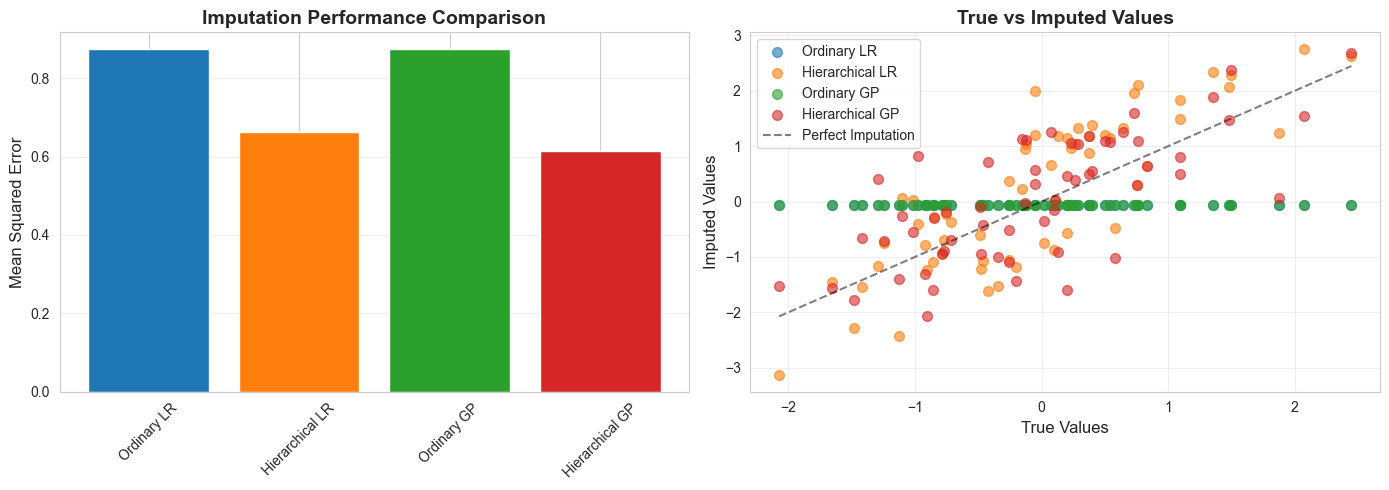


Visualization saved as 'experiment_1_results.png'


In [9]:
# Bar plot of MSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
ax1 = axes[0]
ax1.bar(results['Method'], results['MSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_ylabel('Mean Squared Error', fontsize=12)
ax1.set_title('Imputation Performance Comparison', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Scatter plot: True vs Imputed values
ax2 = axes[1]
ax2.scatter(true_values, imputed_values_lr, alpha=0.6, label='Ordinary LR', s=50)
ax2.scatter(true_values, imputed_values_hlr, alpha=0.6, label='Hierarchical LR', s=50)
ax2.scatter(true_values, imputed_values_gp, alpha=0.6, label='Ordinary GP', s=50)
ax2.scatter(true_values, imputed_values_hgp, alpha=0.6, label='Hierarchical GP', s=50)

# Add diagonal line
min_val = min(true_values.min(), imputed_values_lr.min())
max_val = max(true_values.max(), imputed_values_lr.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Imputation')

ax2.set_xlabel('True Values', fontsize=12)
ax2.set_ylabel('Imputed Values', fontsize=12)
ax2.set_title('True vs Imputed Values', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_1_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'experiment_1_results.png'")

## Conclusion

This experiment demonstrates the direct imputation accuracy of four methods. The hierarchical models should perform better when the data has a clear group structure, as they can leverage group-specific information.